# Metrics time series

In [1]:
!make -C .. agglomeration_extracts

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'agglomeration_extracts'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylandstats as pls
import swisslandstats as sls

from swiss_urbanization.data import settings

In [3]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

agglom_slugs = ['bern', 'lausanne', 'zurich']

class_metrics = [
    'proportion_of_landscape', 'area_mn', 'largest_patch_index',
    'patch_density', 'edge_density', 'fractal_dimension_am',
    'landscape_shape_index', 'euclidean_nearest_neighbor_mn'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

# change PyLandStats metric labels in plots (use custom abbreviations)
pls.settings.metric_label_dict = {
    'proportion_of_landscape': 'PLAND',
    'area_mn': 'MPS',
    'largest_patch_index': 'LPI',
    'patch_density': 'PD',
    'edge_density': 'ED',
    'fractal_dimension_am': 'AWMFD',
    'landscape_shape_index': 'LSI',
    'euclidean_nearest_neighbor_mn': 'ENN',
    'contagion': 'CONTAG',
    'shannon_diversity_index': 'SHDI'
}

In [4]:
agglom_dict = {}
for agglom_slug in agglom_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                          res=ldf.res,
                          nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(ldf['FJ' +
                         urban_nonurban_column[2:4]].value_counts().index[0])
    agglom_dict[agglom_slug] = pls.SpatioTemporalAnalysis(landscapes,
                                                          dates=dates)

## Spatiotemporal analysis of the landscape metrics

In [5]:
# auxiliary function to plot the time series of a metric for all agglomerations
# in one axis
def plot_metric_all_aggloms(ax,
                            metric,
                            class_val=None,
                            agglom_slugs=agglom_slugs):
    for agglom_slug in agglom_slugs:
        agglom_dict[agglom_slug].plot_metric(
            metric,
            class_val=class_val,
            ax=ax,
            plot_kws={'label': agglom_slug.capitalize()})
    ax.margins(y=.5)
    ax.legend()

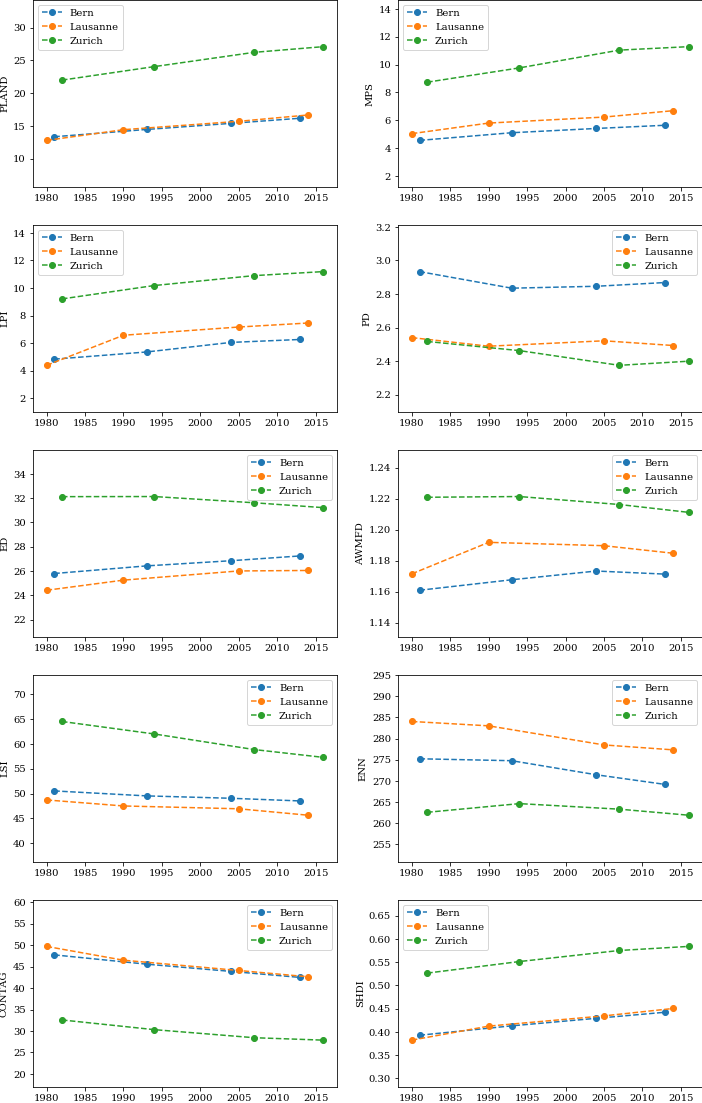

In [6]:
num_cols = 2
num_metrics = len(class_metrics) + len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(class_metrics, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    plot_metric_all_aggloms(ax, metric, class_val=urban_class)

for i, metric in enumerate(landscape_metrics, start=len(class_metrics) + 1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    plot_metric_all_aggloms(ax, metric)

# fig.suptitle('Metrics for patches of urban classes', fontsize=20, y=.92)
fig.savefig('../reports/figures/metrics_time_series.pdf')

## Metric correlations

In [7]:
metrics_df = pd.DataFrame(columns=class_metrics + landscape_metrics)
for agglom_slug in agglom_slugs:
    class_metrics_df = agglom_dict[agglom_slug].compute_class_metrics_df(
        metrics=class_metrics, classes=[urban_class])
    landscape_metrics_df = agglom_dict[
        agglom_slug].compute_landscape_metrics_df(metrics=landscape_metrics)
    agglom_metrics_df = pd.concat([
        class_metrics_df.loc[urban_class][class_metrics],
        landscape_metrics_df[landscape_metrics]
    ],
                                  axis=1)
    # need minmax scaling for correlations to work
    agglom_metrics_df = agglom_metrics_df.apply(pd.to_numeric).apply(
        lambda x: (x.astype(float) - min(x)) / (max(x) - min(x)), axis=0)
    metrics_df = pd.concat([metrics_df, agglom_metrics_df], ignore_index=True)

In [8]:
metrics_df.corr()

metric,proportion_of_landscape,area_mn,largest_patch_index,patch_density,edge_density,fractal_dimension_am,landscape_shape_index,euclidean_nearest_neighbor_mn,contagion,shannon_diversity_index
metric,,,,,,,,,,
proportion_of_landscape,1.000000,0.994628,0.973453,-0.715461,0.309929,0.182301,-0.987459,-0.730462,-0.997935,0.999642
area_mn,0.994628,1.000000,0.967863,-0.774352,0.289020,0.189477,-0.991975,-0.691272,-0.993336,0.995257
largest_patch_index,0.973453,0.967863,1.000000,-0.744344,0.346796,0.303324,-0.943560,-0.672235,-0.978124,0.976867
patch_density,-0.715461,-0.774352,-0.744344,1.000000,-0.102047,-0.246814,0.763524,0.258709,0.721802,-0.723753
edge_density,0.309929,0.289020,0.346796,-0.102047,1.000000,0.874120,-0.263136,-0.429082,-0.327796,0.316953
fractal_dimension_am,0.182301,0.189477,0.303324,-0.246814,0.874120,1.000000,-0.141933,-0.192097,-0.209405,0.196659
landscape_shape_index,-0.987459,-0.991975,-0.943560,0.763524,-0.263136,-0.141933,1.000000,0.709830,0.980124,-0.985749
euclidean_nearest_neighbor_mn,-0.730462,-0.691272,-0.672235,0.258709,-0.429082,-0.192097,0.709830,1.000000,0.703581,-0.718007
contagion,-0.997935,-0.993336,-0.978124,0.721802,-0.327796,-0.209405,0.980124,0.703581,1.000000,-0.999165
